In [1]:
import numpy as np 
import pandas as pd 
import os

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from tensorflow import set_random_seed
os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(2)

In [3]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same",input_shape=(224,224,1),name='conv1_1'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same",name='conv1_2'))
model.add(MaxPooling2D(pool_size=(2,2),name='pool1'))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same",name='conv2_1'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same",name='conv2_2'))
model.add(MaxPooling2D(pool_size=(2,2),name='pool2'))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same",name='conv3_1'))
model.add(BatchNormalization(name='bn3_1'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same",name='conv3_2'))
model.add(BatchNormalization(name='bn3_2'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same",name='conv3_3'))
model.add(MaxPooling2D(pool_size=(2,2),name='pool3'))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv4_1'))
# model.add(BatchNormalization(name='bn4_1'))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv4_2'))
# model.add(BatchNormalization(name='bn4_2'))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv4_3'))
model.add(MaxPooling2D(pool_size=(2,2),name='pool4'))

# model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv5_1'))
# # model.add(BatchNormalization(name='bn5_1'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv5_2'))
# # model.add(BatchNormalization(name='bn5_2'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same",name='conv5_3'))
# model.add(MaxPooling2D(pool_size=(2,2),name='pool5'))

model.add(Flatten(name='flatten'))
model.add(Dense(1024,activation="relu",name='fc1'))
model.add(Dropout(rate=0.5,name='dropout1'))
model.add(Dense(512,activation="relu",name='fc2'))
model.add(Dropout(rate=0.5,name='dropout2'))
model.add(Dense(2,activation="softmax",name='fc3'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

In [4]:
learning_rate = 1e-4
epochs = 3
model.compile(Adam(lr=learning_rate),loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("./chest_xray/train",target_size=(224,224),color_mode="grayscale",shuffle=True,seed=1,batch_size=16)
valid_batches = gen.flow_from_directory("./chest_xray/val", target_size=(224,224),color_mode="grayscale",shuffle=True,seed=1,batch_size=16)
test_batches = gen.flow_from_directory("./chest_xray/test",target_size=(224,224),color_mode="grayscale",shuffle=False,batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
num_steps= 5216//16
model.fit_generator(train_batches,validation_data=valid_batches,epochs=epochs,steps_per_epoch=num_steps,validation_steps=1)

Epoch 1/3
326/326 [==============================] - 61s 187ms/step - loss: 0.2380 - acc: 0.9072 - val_loss: 0.5085 - val_acc: 0.6250
Epoch 2/3
326/326 [==============================] - 51s 156ms/step - loss: 0.1054 - acc: 0.9595 - val_loss: 2.6836 - val_acc: 0.5625
Epoch 3/3
326/326 [==============================] - 51s 157ms/step - loss: 0.0832 - acc: 0.9693 - val_loss: 0.3136 - val_acc: 0.8750


In [7]:
num_steps=624//8
p = model.predict_generator(test_batches, verbose=True,steps=num_steps)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

78/78 [==============================] - 5s 65ms/step


0.9923076923076923
0.902810650887574
0.7740384615384616


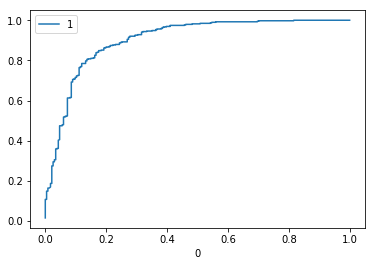

In [8]:
print(recall_score(pre["label"],pre["pre"]))
print(roc_auc_score(pre["label"],pre[1]))
print(accuracy_score(pre["label"],pre["pre"]))

tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)

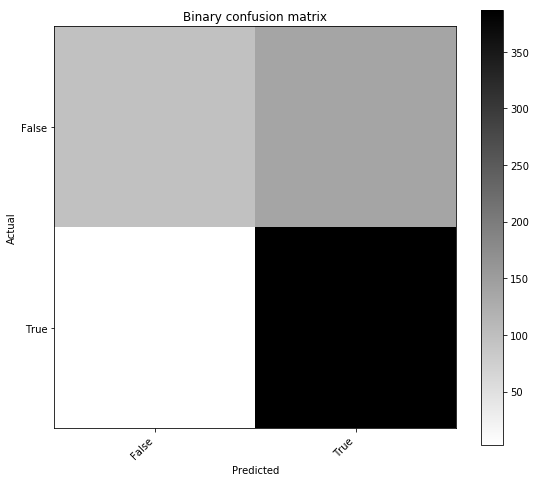

tn, fp, fn, tp: 96 138 3 387
Recall of the model is 0.99
Precision of the model is 0.74


In [9]:
from pandas_ml import ConfusionMatrix

# Get the confusion matrix
cm = ConfusionMatrix(pre["label"],pre["pre"])
plt.figure()
cm.plot()
plt.show()

# Calculate Precision and Recall
tn, fp, fn, tp = cm.TN, cm.FP,cm.FN,cm.TP
print('tn, fp, fn, tp:',tn, fp, fn, tp)

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [12]:
# from keras.models import load_model

# model.save('my_model_1_5.h5')